## Loading of Steinmetz data

includes some visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

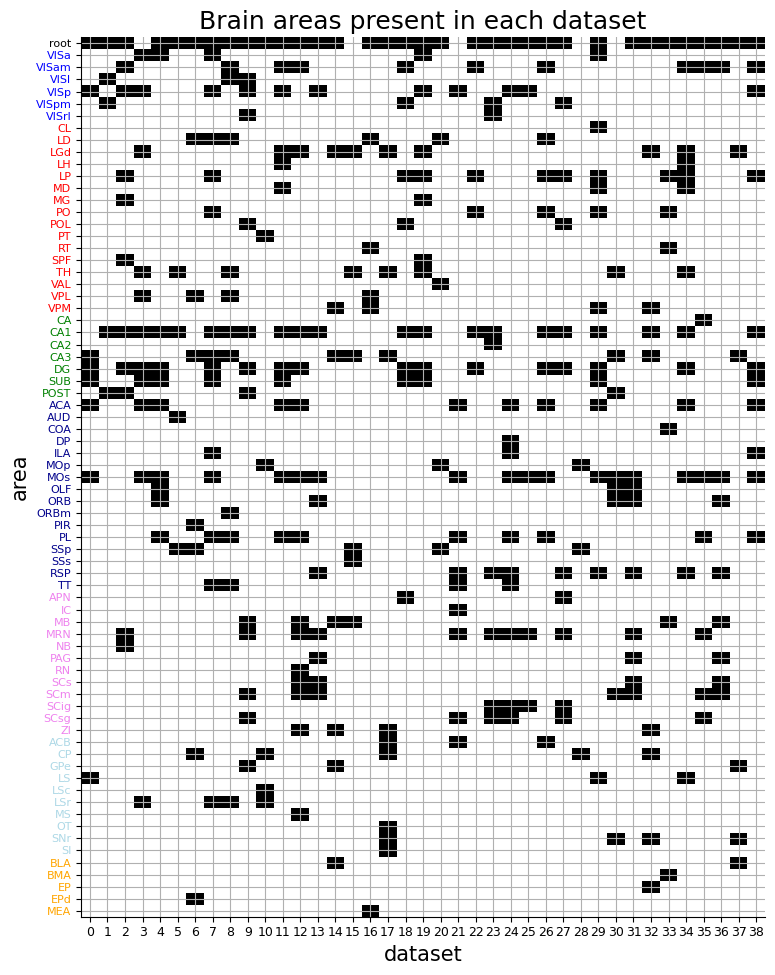

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


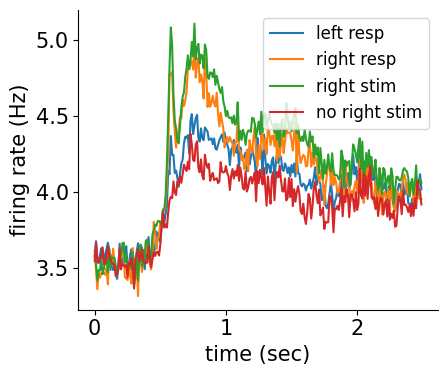

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()


In [ ]:
from numpy.ma.core import shape
from numpy.lib.histograms import histogram

#plt.hist(vis_right,)

#plt.bar(vis_right/250,)

#right_contrast = np.array(39,1)
#left_contrast = np.array(39,1)

vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high

'''
plt.plot(vis_right)
plt.plot(vis_left)
plt.show
'''
total = [vis_left, vis_right]

total_right = []
total_left = []
for sess in range(39):
  dat = alldat[sess]
  #vis_right = [vis_right, dat['contrast_right']]
  total_right = np.append(total_right,dat['contrast_right'])  # 0 - low - high
  total_left = np.append(total_left,dat['contrast_left']) # 0 - low - high

'''
def plot_contrast_hist(total_contrast):
  weights = np.ones_like(total_contrast) / len(total_contrast)
  counts, edges, bars = plt.hist(total_contrast, weights=weights)
  plt.xlabel("Contrast")
  plt.ylabel("Probablity")
  plt.bar_label(bars)
'''

#plot_contrast_hist(total_right)
#plot_contrast_hist(total_left)




'\ndef plot_contrast_hist(total_contrast):\n  weights = np.ones_like(total_contrast) / len(total_contrast)\n  counts, edges, bars = plt.hist(total_contrast, weights=weights)\n  plt.xlabel("Contrast")\n  plt.ylabel("Probablity")\n  plt.bar_label(bars)\n'

Cori


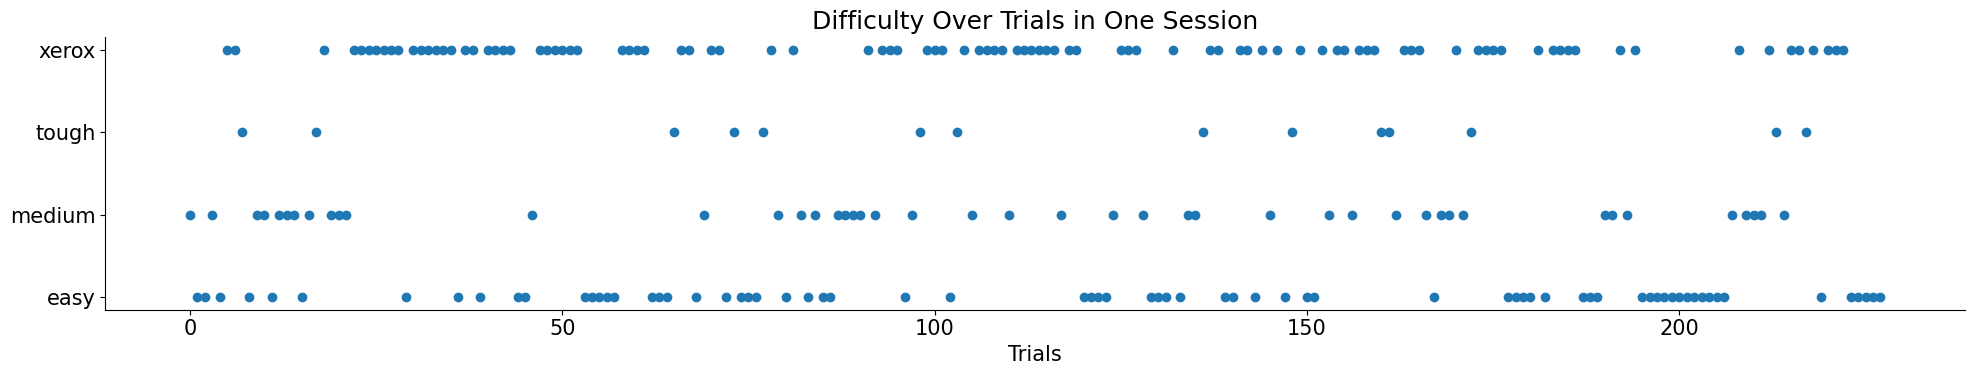

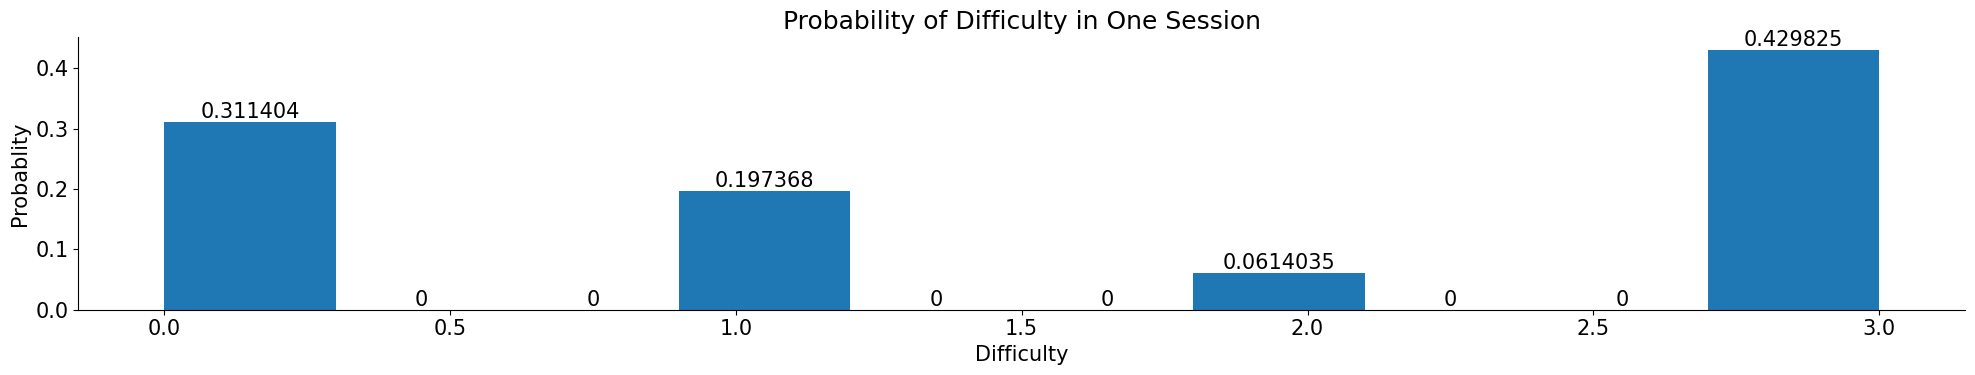

'\nplt.plot(dat["feedback_type"])\ncsum = np.cumsum(dat["feedback_type"])\nprint(csum)\nplt.plot(csum)\nplt.show\n'

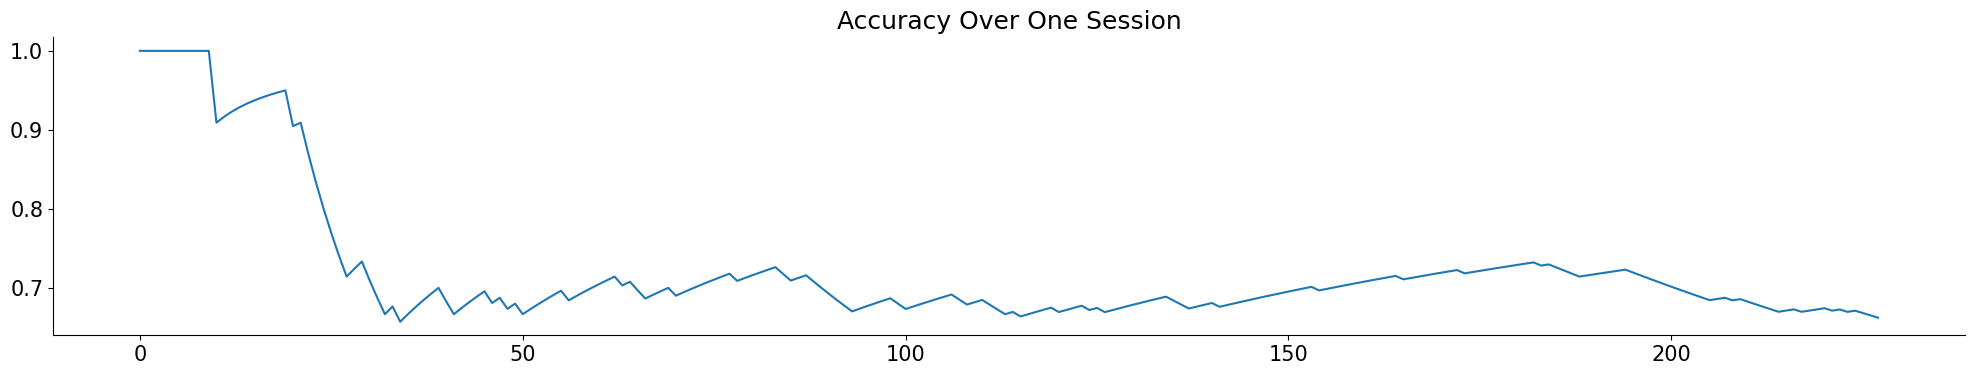

In [ ]:
#Characterize difficulty
dat = alldat[2]
print(dat["mouse_name"])
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high

diff_over_time = []
level = ""
for trial in range(len(vis_right)):
  difference = np.abs(vis_right[trial] - vis_left[trial])
  if difference == 0.75 or difference == 1:
    level = 'easy'
  elif difference == 0.50:
    level = 'medium'
  elif difference == 0.25:
    level = 'tough'
  else:
    level = 'xerox'
  diff_over_time = np.append(diff_over_time, level)

unique, rev = np.unique(diff_over_time, return_inverse=True)
x = list(range(len(vis_right)))

fig,ax=plt.subplots()
ax.scatter(x, rev)
ax.set_yticks(range(len(unique)))
ax.set_yticklabels(unique)
plt.xlabel("Trials")
plt.title("Difficulty Over Trials in One Session")

plt.show()

weights = np.ones_like(rev) / len(rev)
counts, edges, bars = plt.hist(rev, weights=weights)
plt.xlabel("Difficulty")
plt.ylabel("Probablity")
plt.title("Probability of Difficulty in One Session")
plt.bar_label(bars)
plt.show()

feedback = dat["feedback_type"] == 1
accuracy = np.cumsum(feedback)/range(1,len(feedback)+1)
plt.plot(accuracy)
#plt.scatter(vis_right)
#plt.scatter(vis_left)
plt.title("Accuracy Over One Session")

'''
plt.plot(dat["feedback_type"])
csum = np.cumsum(dat["feedback_type"])
print(csum)
plt.plot(csum)
plt.show
'''


In [ ]:
def get_diff_over_time(dat):
  vis_right = dat['contrast_right']  # 0 - low - high
  vis_left = dat['contrast_left']  # 0 - low - high

  diff_over_time = []
  level = ""
  for trial in range(len(vis_right)):
    difference = np.abs(vis_right[trial] - vis_left[trial])
    if difference == 0.75 or difference == 1 or not(vis_right[trial] and vis_left[trial]) :
      level = 'easy'
    elif difference == 0.50:
      level = 'medium'
    elif difference == 0.25:
      level = 'tough'
    else:
      level = 'xerox'
    diff_over_time = np.append(diff_over_time, level)
  return diff_over_time

## Hard Trials

In [ ]:
# Accuracy on hard trials
import pandas as pd

diff_dict = {'easy' : 0, 'medium' : 0, 'tough' : 1, 'xerox' : 1}

df = pd.DataFrame(columns=['mouse','% hard correct','num trials','% hard assigned'])

for i in range(39):
  index = i
  dat = alldat[index]
  diff_over_time = get_diff_over_time(dat)

  diff_num = [diff_dict[val] for val in diff_over_time]
  hard_only = dat['feedback_type']*diff_num

  hard_ser = pd.Series(hard_only)
  hard_vals = hard_ser.value_counts()

  row = pd.DataFrame([[dat['mouse_name'], round(100*hard_vals[1]/(hard_vals[1]+hard_vals[-1]), 2), len(hard_only),
  round(100*(len(hard_only)-hard_vals[0])/len(hard_only),2)]],
                    columns=['mouse','% hard correct', 'num trials','% hard assigned'])
  df = pd.concat([df,row], ignore_index=True)
  df.index += 1
  df.index.name = 'session'
print(df)

             mouse  % hard correct num trials  % hard assigned
session                                                       
1             Cori           48.00        214            11.68
2             Cori           46.88        251            12.75
3             Cori           61.54        228            11.40
4        Forssmann           46.67        249            18.07
5        Forssmann           45.83        254            18.90
6        Forssmann           67.27        290            18.97
7        Forssmann           58.54        252            16.27
8            Hench           47.83        250             9.20
9            Hench           33.33        372             9.68
10           Hench           44.83        447            12.98
11           Hench           56.10        342            11.99
12       Lederberg           81.82        340            12.94
13       Lederberg           73.68        300            12.67
14       Lederberg           64.71        268          

In [ ]:
#@title Extra info (reaction time variance)
# Reaction time on hard trials

# df = pd.DataFrame(columns=['mouse', 'reaction time mean (ms)', 'reaction time variance (s)'])

# for i in range(39):
#   index = i
#   dat = alldat[index]
#   diff_over_time = get_diff_over_time(dat)

#   diff_num = [diff_dict[val] for val in diff_over_time]
#   hard_only = dat['feedback_type']*diff_num

#   hard_ser = pd.Series(hard_only)
#   hard_vals = hard_ser.value_counts()

#   reaction = dat['reaction_time'][:,0]
#   reactions = []
#   for i, j in zip(reaction, hard_only):
#     if (j**2>0) and (i!=np.nan) and (i!=np.inf):
#       reactions.append(i)
#   var_reaction = 0.001*np.array(reactions).var()
#   mean_reaction = np.array(reactions).mean()

#   row = pd.DataFrame([[dat['mouse_name'], round(mean_reaction,2), round(var_reaction,2)]],
#                   columns=['mouse', 'reaction time mean (ms)', 'reaction time variance (s)'])
#   df = pd.concat([df,row], ignore_index=True)
#   df.index += 1
#   df.index.name = 'session'
# print(df)

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['mouse', 'accuracy', 'reaction time mean (ms)'])

for i in range(39):
  index = i
  dat = alldat[index]
  diff_over_time = get_diff_over_time(dat)

  diff_num = [diff_dict[val] for val in diff_over_time]
  hard_only = dat['feedback_type']*diff_num

  hard_ser = pd.Series(hard_only)
  hard_vals = hard_ser.value_counts()
  reaction = dat['reaction_time'][:,0]
  reactions = []
  for i, j in zip(reaction, hard_only):
    if (j**2>0) and (i!=np.nan) and (i!=np.inf):
      reactions.append(i)
  mean_reaction = np.array(reactions).mean()
  row = pd.DataFrame([[dat['mouse_name'], round(100*hard_vals[1]/(hard_vals[1]+hard_vals[-1]),2), round(mean_reaction,2)]],
                  columns=['mouse', 'accuracy', 'reaction time mean (ms)'])
  df = pd.concat([df,row], ignore_index=True)
  df.index += 1
  df.index.name = 'session'
print(df)

             mouse  accuracy  reaction time mean (ms)
session                                              
1             Cori     48.00                   456.67
2             Cori     46.88                   484.48
3             Cori     61.54                   440.40
4        Forssmann     46.67                   489.23
5        Forssmann     45.83                   503.44
6        Forssmann     67.27                   426.80
7        Forssmann     58.54                   412.00
8            Hench     47.83                   466.32
9            Hench     33.33                   367.14
10           Hench     44.83                   538.67
11           Hench     56.10                   454.44
12       Lederberg     81.82                   179.32
13       Lederberg     73.68                   232.11
14       Lederberg     64.71                   252.35
15       Lederberg     68.29                   274.75
16       Lederberg     70.37                   339.62
17       Lederberg     70.97

Text(0.5, 1.0, 'Mean Session Accuracy vs. Mean Session Reaction Time on Difficult Trials')

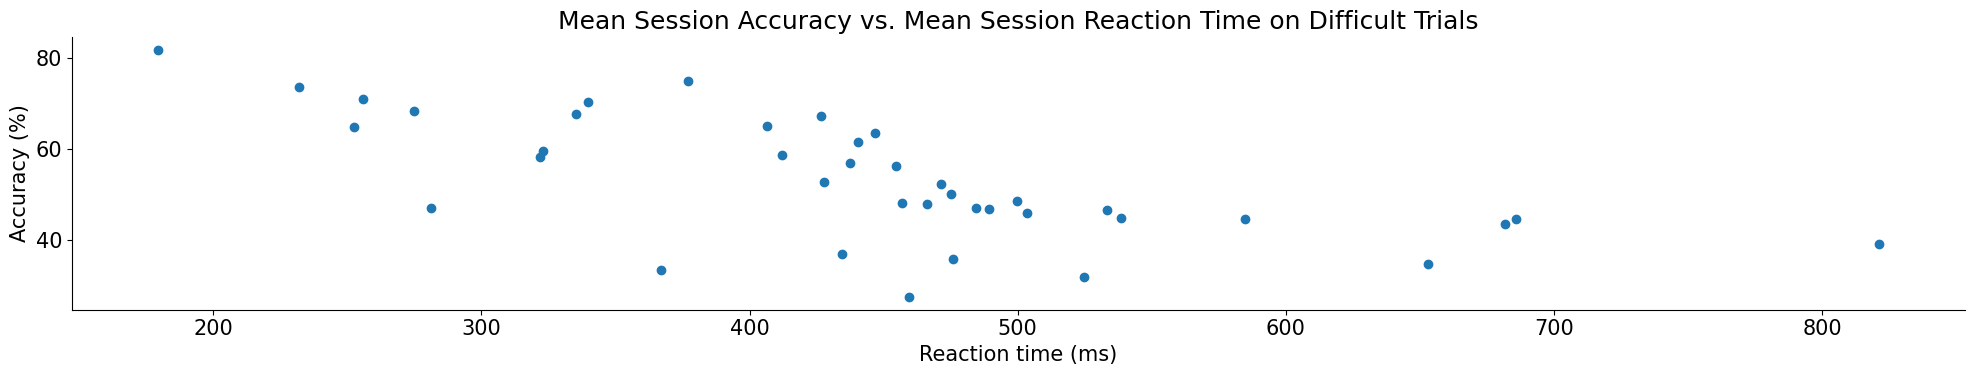

In [ ]:
fig,ax = plt.subplots(1)

x = df['reaction time mean (ms)']
y = df['accuracy']

ax.scatter(x,y)
plt.xlabel('Reaction time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Mean Session Accuracy vs. Mean Session Reaction Time on Difficult Trials')

In [ ]:
alldat[0].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

**CREATE A DICTIONARY OF MOUSES WITH HOW MANY SESSIONS IN EACH**

In [ ]:
dat = alldat[11]
print(dat["mouse_name"])

mouse = {0: [0,1,2], 1: [3,4,5,6], 2: [7,8,9,10], 3: [11,12,13,14,15,16,17], 4: [18,19,20], 5: [21,22,23], 6: [24,25,26,27,28], 7: [29,30,31,32,33], 8: [34,35,36,37], 9:[38]}

print(mouse.keys())
print(mouse[0])



Lederberg
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
[0, 1, 2]


In [ ]:
# dictionary with neural data for each mouse

#init dict
neural_activity = {}

for i in range(alldat.size):
  dat = alldat[i]
  neural_activity[i] = dat['spks']


In [ ]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

IndexError: ignored

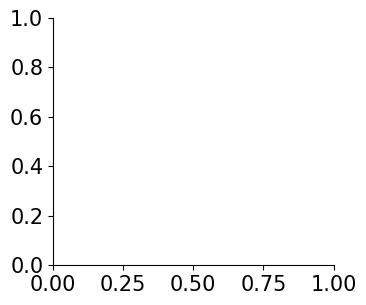

In [ ]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

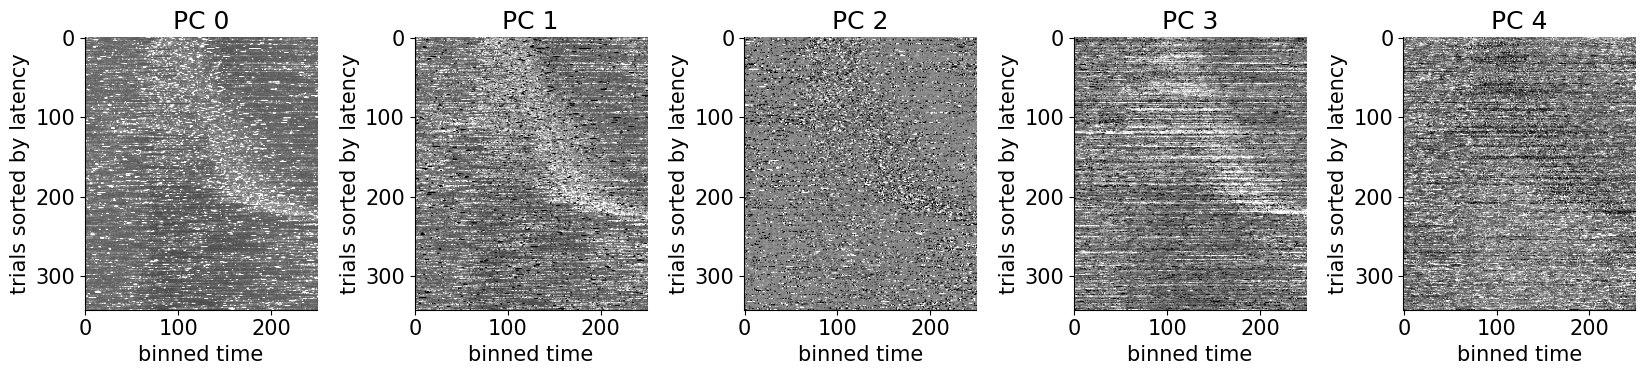

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
import numpy as np

fname1 =['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']

alldat = np.array([])
for j in range(len(fname1)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))